## Fine-tuning the logistic regression model with Grad-CAM explainability by boosting top features with a weight of 5, 10 and 15

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Custom TfidfVectorizer to boost weights of important terms
class CustomTfidfVectorizer(TfidfVectorizer):
    def __init__(self, *args, **kwargs):
        self.important_terms = kwargs.pop('important_terms', [])
        self.boost_factor = kwargs.pop('boost_factor', 1.5)
        super().__init__(*args, **kwargs)
    
    def fit_transform(self, raw_documents, y=None):
        X = super().fit_transform(raw_documents)
        self._apply_boost(X)
        return X
    
    def transform(self, raw_documents):
        X = super().transform(raw_documents)
        self._apply_boost(X)
        return X
    
    def _apply_boost(self, X):
        feature_array = np.array(self.get_feature_names_out())
        boost_indices = np.where(np.isin(feature_array, self.important_terms))[0]
        if len(boost_indices) > 0:
            X[:, boost_indices] *= self.boost_factor

# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Function to train and evaluate the logistic regression model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, important_terms, boost_factor=1.5):
    # Vectorize the text data
    vectorizer = CustomTfidfVectorizer(max_features=100000, ngram_range=(1, 2), important_terms=important_terms, boost_factor=boost_factor)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

    # Set hyperparameters
    input_size = X_train_tensor.shape[1]
    output_size = len(label_encoder.classes_)
    learning_rate = 0.001
    num_epochs = 10
    batch_size = 64

    # Initialize the model, criterion, and optimizer
    model = LogisticRegression(input_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        target_names = [str(label) for label in label_encoder.classes_]
        print(classification_report(y_test_tensor, predicted, target_names=target_names))

# Dictionary of datasets and corresponding top features
datasets = {
    '1960s': (df_1960s, top_features_1960s),
    '1970s': (df_1970s, top_features_1970s),
    '1980s': (df_1980s, top_features_1980s),
    '1990s': (df_1990s, top_features_1990s)
}

boost_factors = [5.0, 10.0, 15.0]

for dataset_name, (df, important_terms) in datasets.items():
    print(f"\nClassification Report for {dataset_name}:")
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=42)
    for boost_factor in boost_factors:
        print(f"Trying boost factor: {boost_factor}")
        train_and_evaluate_model(X_train, y_train, X_test, y_test, important_terms, boost_factor)


Classification Report for 1960s:
Trying boost factor: 5.0
Epoch 1, Loss: 14.979928374290466
Epoch 2, Loss: 13.277457237243652
Epoch 3, Loss: 12.048171758651733
Epoch 4, Loss: 11.050606310367584
Epoch 5, Loss: 10.175871789455414
Epoch 6, Loss: 9.37772262096405
Epoch 7, Loss: 8.685939192771912
Epoch 8, Loss: 8.034533858299255
Epoch 9, Loss: 7.537919461727142
Epoch 10, Loss: 7.0093055963516235
              precision    recall  f1-score   support

           0       0.57      0.30      0.39        43
           1       0.65      0.41      0.51        58
           2       0.63      0.85      0.72       117

    accuracy                           0.62       218
   macro avg       0.61      0.52      0.54       218
weighted avg       0.62      0.62      0.60       218

Trying boost factor: 10.0
Epoch 1, Loss: 14.69938462972641
Epoch 2, Loss: 12.393248498439789
Epoch 3, Loss: 10.774988830089569
Epoch 4, Loss: 9.444892883300781
Epoch 5, Loss: 8.375475823879242
Epoch 6, Loss: 7.46900168061256

Epoch 1, Loss: 9.993704915046692
Epoch 2, Loss: 7.542352020740509
Epoch 3, Loss: 6.325818479061127
Epoch 4, Loss: 5.424593269824982
Epoch 5, Loss: 4.9521253407001495
Epoch 6, Loss: 4.388097494840622
Epoch 7, Loss: 4.06457582116127
Epoch 8, Loss: 3.7908160388469696
Epoch 9, Loss: 3.6852015256881714
Epoch 10, Loss: 3.4721933603286743
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        96
           1       0.61      0.50      0.55        28
           2       0.46      0.48      0.47        27

    accuracy                           0.72       151
   macro avg       0.63      0.61      0.62       151
weighted avg       0.72      0.72      0.72       151



## fine-tuned linear regression model without boosting top features

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import joblib
import os

# Define a PyTorch model class
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Define a custom classifier that uses PyTorch
class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, num_epochs=5, batch_size=32):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.vectorizer = CountVectorizer()
        self.label_encoder = LabelEncoder()
        self.model = None

    def fit(self, X, y):
        # Vectorize the text data
        X_vec = self.vectorizer.fit_transform(X)

        # Encode the labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X_vec.toarray(), dtype=torch.float32)
        y_tensor = torch.tensor(y_encoded, dtype=torch.long)

        # Set hyperparameters
        self.input_size = X_tensor.shape[1]
        self.output_size = len(self.label_encoder.classes_)

        # Initialize the model, criterion, and optimizer
        self.model = LogisticRegression(self.input_size, self.output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Create DataLoader
        train_dataset = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # Training loop
        for epoch in range(self.num_epochs):
            self.model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        # Vectorize the text data
        X_vec = self.vectorizer.transform(X)

        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X_vec.toarray(), dtype=torch.float32)

        # Evaluation
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
        return self.label_encoder.inverse_transform(predicted.numpy())

# Define a custom scorer function
def f1_scorer(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']

# Example dictionary of datasets (replace with your actual datasets)
datasets = {
    '1960s': df_1960s,
    '1970s': df_1970s,
    '1980s': df_1980s,
    '1990s': df_1990s
}

# Define hyperparameter ranges
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [5, 10, 20],
    'batch_size': [32, 64, 128]
}

for dataset_name, df in datasets.items():
    print(f"\nHyperparameter Tuning for {dataset_name}:")
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=42)
    
    # Initialize the classifier
    pytorch_clf = PyTorchClassifier()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=pytorch_clf, param_grid=param_grid, scoring=make_scorer(f1_scorer, greater_is_better=True), cv=3, verbose=1)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and classification report
    print("Best Hyperparameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Best Classification Report:\n", classification_report(y_test, y_pred))
    
    # Save the best model, vectorizer, and label encoder
    model_save_path = f"best_model_{dataset_name}.pth"
    vectorizer_save_path = f"vectorizer_{dataset_name}.pkl"
    label_encoder_save_path = f"label_encoder_{dataset_name}.pkl"
    
    torch.save({
        'model_state_dict': best_model.model.state_dict(),
        'input_size': best_model.input_size,
        'output_size': best_model.output_size
    }, model_save_path)
    
    joblib.dump(best_model.vectorizer, vectorizer_save_path)
    joblib.dump(best_model.label_encoder, label_encoder_save_path)

    print(f"Saved best model to {model_save_path}")
    print(f"Saved vectorizer to {vectorizer_save_path}")
    print(f"Saved label encoder to {label_encoder_save_path}")


Hyperparameter Tuning for 1960s:
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'batch_size': 32, 'learning_rate': 0.001, 'num_epochs': 10}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.40      0.47        43
           1       0.51      0.50      0.50        58
           2       0.67      0.76      0.71       117

    accuracy                           0.62       218
   macro avg       0.59      0.55      0.56       218
weighted avg       0.61      0.62      0.61       218

Saved best model to best_model_1960s.pth
Saved vectorizer to vectorizer_1960s.pkl
Saved label encoder to label_encoder_1960s.pkl

Hyperparameter Tuning for 1970s:
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 5}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.6

## Finetuned linear regression model without stopwords and without boosting top features

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from nltk.corpus import stopwords as nltk_stopwords
import nltk

# Download NLTK stopwords for Dutch
nltk.download('stopwords')
nltk_stopwords = set(nltk_stopwords.words('dutch'))

# Define a PyTorch model class
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Define a custom classifier that uses PyTorch
class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, num_epochs=5, batch_size=32, stopwords=None):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.stopwords = stopwords if stopwords else set()
        self.vectorizer = CountVectorizer(stop_words=self.stopwords)
        self.label_encoder = LabelEncoder()
        self.model = None

    def remove_stopwords(self, text):
        return ' '.join([word for word in text.split() if word.lower() not in self.stopwords])

    def fit(self, X, y):
        # Remove stopwords from X
        X = [self.remove_stopwords(text) for text in X]

        # Vectorize the text data
        X_vec = self.vectorizer.fit_transform(X)

        # Encode the labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X_vec.toarray(), dtype=torch.float32)
        y_tensor = torch.tensor(y_encoded, dtype=torch.long)

        # Set hyperparameters
        input_size = X_tensor.shape[1]
        output_size = len(self.label_encoder.classes_)

        # Initialize the model, criterion, and optimizer
        self.model = LogisticRegression(input_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Create DataLoader
        train_dataset = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # Training loop
        for epoch in range(self.num_epochs):
            self.model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        # Remove stopwords from X
        X = [self.remove_stopwords(text) for text in X]

        # Vectorize the text data
        X_vec = self.vectorizer.transform(X)

        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X_vec.toarray(), dtype=torch.float32)

        # Evaluation
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
        return self.label_encoder.inverse_transform(predicted.numpy())

# Define a custom scorer function
def f1_scorer(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']

# Dictionary of datasets
datasets = {
    '1960s': df_1960s,
    '1970s': df_1970s,
    '1980s': df_1980s,
    '1990s': df_1990s
}

# Define hyperparameter ranges
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [5, 10, 20],
    'batch_size': [32, 64, 128]
}

for dataset_name, df in datasets.items():
    print(f"\nHyperparameter Tuning for {dataset_name}:")
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=42)
    
    # Initialize the classifier with Dutch stopwords
    pytorch_clf = PyTorchClassifier(stopwords=nltk_stopwords)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=pytorch_clf, param_grid=param_grid, scoring=make_scorer(f1_scorer, greater_is_better=True), cv=3, verbose=1)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and classification report
    print("Best Hyperparameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Best Classification Report:\n", classification_report(y_test, y_pred))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Hyperparameter Tuning for 1960s:
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'batch_size': 32, 'learning_rate': 0.01, 'num_epochs': 10}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44        43
           1       0.50      0.47      0.48        58
           2       0.67      0.74      0.70       117

    accuracy                           0.60       218
   macro avg       0.56      0.53      0.54       218
weighted avg       0.59      0.60      0.59       218


Hyperparameter Tuning for 1970s:
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 5}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.55      0.58        69
           1       0.43      0.09      0.15        34
           2       0.64      0.84      0.73 

## finetuned linear regression model with boosting top features

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Custom TfidfVectorizer to boost weights of important terms
class CustomTfidfVectorizer(TfidfVectorizer):
    def __init__(self, *args, **kwargs):
        self.important_terms = kwargs.pop('important_terms', [])
        self.boost_factor = kwargs.pop('boost_factor', 1.5)
        super().__init__(*args, **kwargs)
    
    def fit_transform(self, raw_documents, y=None):
        X = super().fit_transform(raw_documents)
        self._apply_boost(X)
        return X
    
    def transform(self, raw_documents):
        X = super().transform(raw_documents)
        self._apply_boost(X)
        return X
    
    def _apply_boost(self, X):
        feature_array = np.array(self.get_feature_names_out())
        boost_indices = np.where(np.isin(feature_array, self.important_terms))[0]
        if len(boost_indices) > 0:
            X[:, boost_indices] *= self.boost_factor

# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Function to train and evaluate the logistic regression model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, important_terms, boost_factor=1.5, learning_rate=0.001, num_epochs=10, batch_size=64):
    # Vectorize the text data
    vectorizer = CustomTfidfVectorizer(max_features=100000, ngram_range=(1, 2), important_terms=important_terms, boost_factor=boost_factor)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

    # Set hyperparameters
    input_size = X_train_tensor.shape[1]
    output_size = len(label_encoder.classes_)

    # Initialize the model, criterion, and optimizer
    model = LogisticRegression(input_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        target_names = [str(label) for label in label_encoder.classes_]
        print(classification_report(y_test_tensor, predicted, target_names=target_names))

# Dictionary of datasets and corresponding top features
datasets = {
    '1960s': (df_1960s, top_features_1960s),
    '1970s': (df_1970s, top_features_1970s),
    '1980s': (df_1980s, top_features_1980s),
    '1990s': (df_1990s, top_features_1990s)
}

# Predefined best hyperparameters for each decade
best_hyperparameters = {
    '1960s': {'batch_size': 64, 'learning_rate': 0.01, 'num_epochs': 20},
    '1970s': {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 5},
    '1980s': {'batch_size': 32, 'learning_rate': 0.001, 'num_epochs': 20},
    '1990s': {'batch_size': 128, 'learning_rate': 0.1, 'num_epochs': 20}
}

boost_factors = [5.0, 10.0, 15.0]

for dataset_name, (df, important_terms) in datasets.items():
    print(f"\nClassification Report for {dataset_name}:")
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=42)
    
    # Get best hyperparameters for the current decade
    best_params = best_hyperparameters[dataset_name]
    
    for boost_factor in boost_factors:
        print(f"Trying boost factor: {boost_factor}")
        train_and_evaluate_model(
            X_train, y_train, X_test, y_test, important_terms, boost_factor,
            learning_rate=best_params['learning_rate'],
            num_epochs=best_params['num_epochs'],
            batch_size=best_params['batch_size']
        )


Classification Report for 1960s:
Trying boost factor: 5.0
Epoch 1, Loss: 14.112584888935089
Epoch 2, Loss: 5.799548536539078
Epoch 3, Loss: 3.4676247239112854
Epoch 4, Loss: 2.8402969539165497
Epoch 5, Loss: 2.5103835612535477
Epoch 6, Loss: 2.2901265025138855
Epoch 7, Loss: 2.1829572319984436
Epoch 8, Loss: 2.232019990682602
Epoch 9, Loss: 2.144555702805519
Epoch 10, Loss: 2.0953532829880714
Epoch 11, Loss: 2.0856315419077873
Epoch 12, Loss: 1.952342115342617
Epoch 13, Loss: 1.995336852967739
Epoch 14, Loss: 1.953314907848835
Epoch 15, Loss: 1.9269966036081314
Epoch 16, Loss: 1.9810539707541466
Epoch 17, Loss: 1.9578952640295029
Epoch 18, Loss: 1.9230052530765533
Epoch 19, Loss: 1.987641267478466
Epoch 20, Loss: 1.9772274494171143
              precision    recall  f1-score   support

           0       0.58      0.42      0.49        43
           1       0.65      0.52      0.58        58
           2       0.68      0.82      0.74       117

    accuracy                           

Epoch 1, Loss: 6.809078931808472
Epoch 2, Loss: 3.28716117143631
Epoch 3, Loss: 2.985685557126999
Epoch 4, Loss: 2.8929489254951477
Epoch 5, Loss: 2.3467504680156708
Epoch 6, Loss: 2.1622360944747925
Epoch 7, Loss: 2.115762948989868
Epoch 8, Loss: 2.093347430229187
Epoch 9, Loss: 2.1214960515499115
Epoch 10, Loss: 2.111079126596451
Epoch 11, Loss: 2.0286644995212555
Epoch 12, Loss: 1.966170072555542
Epoch 13, Loss: 2.1833983063697815
Epoch 14, Loss: 1.9615790843963623
Epoch 15, Loss: 1.8430953919887543
Epoch 16, Loss: 1.9186724126338959
Epoch 17, Loss: 1.8930894434452057
Epoch 18, Loss: 1.8752915561199188
Epoch 19, Loss: 1.858263835310936
Epoch 20, Loss: 1.9129567593336105
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        96
           1       0.54      0.46      0.50        28
           2       0.44      0.59      0.51        27

    accuracy                           0.71       151
   macro avg       0.61      0.62      0.61   

## fine-tuned SVM model without boosting top features

In [95]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer

# Define a custom scorer function
def f1_scorer(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']

# Dictionary of datasets
datasets = {
    '1960s': df_1960s,
    '1970s': df_1970s,
    '1980s': df_1980s,
    '1990s': df_1990s
}

# Define hyperparameter ranges
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Only used for 'poly' kernel, ignored otherwise
    'gamma': ['scale', 'auto']  # Used for 'rbf', 'poly', and 'sigmoid' kernels
}

for dataset_name, df in datasets.items():
    print(f"\nHyperparameter Tuning for {dataset_name}:")
    
    X = df['text']
    y = df['labels']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vectorize the text data
    tfidf_vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1, 2))
    X_train_vec = tfidf_vectorizer.fit_transform(X_train)
    X_test_vec = tfidf_vectorizer.transform(X_test)

    # Initialize the SVM classifier
    svm_clf = SVC(probability=True)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, scoring=make_scorer(f1_scorer, greater_is_better=True), cv=3, verbose=1)

    # Fit GridSearchCV
    grid_search.fit(X_train_vec, y_train)
    
    # Print the best parameters and classification report
    print("Best Hyperparameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vec)
    print("Best Classification Report:\n", classification_report(y_test, y_pred))


Hyperparameter Tuning for 1960s:
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.42      0.47        43
           1       0.63      0.47      0.53        58
           2       0.65      0.79      0.71       117

    accuracy                           0.63       218
   macro avg       0.61      0.56      0.57       218
weighted avg       0.62      0.63      0.62       218


Hyperparameter Tuning for 1970s:
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.54      0.53        69
           1       0.38      0.15      0.21        34
           2       0.63      0.75      0.68       102

    accuracy                           0.58       205
   macro avg       0.51      0.48      0.47       205
weighted avg       0.55      0.58      0.55       205


Hyperparameter Tuning for 1980s:
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.76      0.68       102
           1       0.48      0.25      0.33        44
           2       0.70      0.69      0.70       118

    accuracy                           0.64       264
   macro avg       0.60      0.57      0.57       264
weighted avg       0.63      0.64      0.63       264


Hyperparameter Tuning for 1990s:
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83        96
           1       0.63      0.43      0.51        28
           2       0.44      0.41      0.42        27

    accuracy                           0.71       151
   macro avg       0.62      0.57      0.59       151
weighted avg       0.69      0.71      0.70       151



## Finetuned SVM model without stopwords and without boosting features

In [110]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer

# Define a custom scorer function
def f1_scorer(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True)['weighted avg']['f1-score']

# Dictionary of datasets
datasets = {
    '1960s': df_1960s,
    '1970s': df_1970s,
    '1980s': df_1980s,
    '1990s': df_1990s
}

# Define hyperparameter ranges
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Only used for 'poly' kernel, ignored otherwise
    'gamma': ['scale', 'auto']  # Used for 'rbf', 'poly', and 'sigmoid' kernels
}

# List of Dutch stopwords
dutch_stopwords = [
    'de', 'het', 'een', 'en', 'van', 'ik', 'te', 'dat', 'die', 'in', 'zij', 
    'jij', 'je', 'mij', 'hij', 'het', 'dit', 'dat', 'ons', 'we', 'we', 'jullie', 
    'hem', 'haar', 'hen', 'hun', 'ons', 'onze', 'u', 'aan', 'maar', 'met', 
    'door', 'om', 'tot', 'tegen', 'op', 'na', 'naast', 'tussen', 'onder', 
    'boven', 'binnen', 'buiten', 'over', 'naar'
]

for dataset_name, df in datasets.items():
    print(f"\nHyperparameter Tuning for {dataset_name}:")
    
    X = df['text']
    y = df['labels']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vectorize the text data with Dutch stopwords removal
    tfidf_vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1, 2), stop_words=dutch_stopwords)
    X_train_vec = tfidf_vectorizer.fit_transform(X_train)
    X_test_vec = tfidf_vectorizer.transform(X_test)

    # Initialize the SVM classifier
    svm_clf = SVC(probability=True)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, scoring=make_scorer(f1_scorer, greater_is_better=True), cv=3, verbose=1)

    # Fit GridSearchCV
    grid_search.fit(X_train_vec, y_train)
    
    # Print the best parameters and classification report
    print("Best Hyperparameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vec)
    print("Best Classification Report:\n", classification_report(y_test, y_pred))


Hyperparameter Tuning for 1960s:
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.40      0.46        43
           1       0.63      0.47      0.53        58
           2       0.65      0.79      0.71       117

    accuracy                           0.63       218
   macro avg       0.61      0.55      0.57       218
weighted avg       0.62      0.63      0.62       218


Hyperparameter Tuning for 1970s:
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

Best Hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.52      0.55        69
           1       0.38      0.15      0.21        34
           2       0.64      0.81      0.72       102

    accuracy                           0.60       205
   macro avg       0.53      0.49      0.49       205
weighted avg       0.58      0.60      0.58       205


Hyperparameter Tuning for 1980s:
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.75      0.68       102
           1       0.50      0.23      0.31        44
           2       0.71      0.71      0.71       118

    accuracy                           0.65       264
   macro avg       0.61      0.56      0.57       264
weighted avg       0.64      0.65      0.63       264


Hyperparameter Tuning for 1990s:
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schol\anaconda3\lib\site-packages\sklearn\metr

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83        96
           1       0.65      0.46      0.54        28
           2       0.44      0.41      0.42        27

    accuracy                           0.72       151
   macro avg       0.63      0.58      0.60       151
weighted avg       0.70      0.72      0.70       151



## fine-tuned SVM model with boosting top features

In [96]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Custom TfidfVectorizer to boost weights of important terms
class CustomTfidfVectorizer(TfidfVectorizer):
    def __init__(self, *args, **kwargs):
        self.important_terms = kwargs.pop('important_terms', [])
        self.boost_factor = kwargs.pop('boost_factor', 1.5)
        super().__init__(*args, **kwargs)
    
    def fit_transform(self, raw_documents, y=None):
        X = super().fit_transform(raw_documents)
        self._apply_boost(X)
        return X
    
    def transform(self, raw_documents):
        X = super().transform(raw_documents)
        self._apply_boost(X)
        return X
    
    def _apply_boost(self, X):
        feature_array = np.array(self.get_feature_names_out())
        boost_indices = np.where(np.isin(feature_array, self.important_terms))[0]
        if len(boost_indices) > 0:
            X[:, boost_indices] *= self.boost_factor

# Function to train and evaluate the SVM model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, important_terms, boost_factor=1.5, C=1.0, kernel='linear'):
    # Vectorize the text data
    vectorizer = CustomTfidfVectorizer(max_features=100000, ngram_range=(1, 2), important_terms=important_terms, boost_factor=boost_factor)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Initialize the SVM classifier
    svm_model = make_pipeline(StandardScaler(with_mean=False), SVC(C=C, kernel=kernel, probability=True))

    # Train the SVM model
    svm_model.fit(X_train_vec, y_train_encoded)

    # Evaluation
    y_pred = svm_model.predict(X_test_vec)
    target_names = [str(label) for label in label_encoder.classes_]
    print(classification_report(y_test_encoded, y_pred, target_names=target_names))

# Dictionary of datasets and corresponding top features
datasets = {
    '1960s': (df_1960s, top_features_1960s_svm),
    '1970s': (df_1970s, top_features_1970s_svm),
    '1980s': (df_1980s, top_features_1980s_svm),
    '1990s': (df_1990s, top_features_1990s_svm)
}

# Predefined best hyperparameters for each decade
best_hyperparameters = {
    '1960s': {'C': 10.0, 'kernel': 'linear'},
    '1970s': {'C': 10.0, 'kernel': 'rbf'},
    '1980s': {'C': 10.0, 'kernel': 'linear'},
    '1990s': {'C': 10.0, 'kernel': 'rbf'}
}

boost_factors = [5.0, 10.0, 15.0]

for dataset_name, (df, important_terms) in datasets.items():
    print(f"\nClassification Report for {dataset_name}:")
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=42)
    
    # Get best hyperparameters for the current decade
    best_params = best_hyperparameters[dataset_name]
    
    for boost_factor in boost_factors:
        print(f"Trying boost factor: {boost_factor}")
        train_and_evaluate_model(
            X_train, y_train, X_test, y_test, important_terms, boost_factor,
            C=best_params['C'],
            kernel=best_params['kernel']
        )


Classification Report for 1960s:
Trying boost factor: 5.0
              precision    recall  f1-score   support

           0       0.56      0.23      0.33        43
           1       0.65      0.38      0.48        58
           2       0.60      0.85      0.70       117

    accuracy                           0.60       218
   macro avg       0.60      0.49      0.50       218
weighted avg       0.60      0.60      0.57       218

Trying boost factor: 10.0
              precision    recall  f1-score   support

           0       0.56      0.23      0.33        43
           1       0.65      0.38      0.48        58
           2       0.60      0.85      0.70       117

    accuracy                           0.60       218
   macro avg       0.60      0.49      0.50       218
weighted avg       0.60      0.60      0.57       218

Trying boost factor: 15.0
              precision    recall  f1-score   support

           0       0.56      0.23      0.33        43
           1      

## fine-tuned SVM model with boosting top features and removing stopwords

In [122]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# List of Dutch stopwords to remove
dutch_stopwords = [
    'de', 'het', 'een', 'en', 'van', 'ik', 'te', 'dat', 'die', 'in', 'zij', 
    'jij', 'je', 'mij', 'hij', 'het', 'dit', 'dat', 'ons', 'we', 'we', 'jullie', 
    'hem', 'haar', 'hen', 'hun', 'ons', 'onze', 'u', 'aan', 'maar', 'met', 
    'door', 'om', 'tot', 'tegen', 'op', 'na', 'naast', 'tussen', 'onder', 
    'boven', 'binnen', 'buiten', 'over', 'naar'
]

# Custom TfidfVectorizer to boost weights of important terms and remove Dutch stopwords
class CustomTfidfVectorizer(TfidfVectorizer):
    def __init__(self, *args, **kwargs):
        self.important_terms = kwargs.pop('important_terms', [])
        self.boost_factor = kwargs.pop('boost_factor', 1.5)
        super().__init__(*args, **kwargs)
        self.stop_words = set(self.get_stop_words())

    def get_stop_words(self):
        return dutch_stopwords  # Use the Dutch stopwords list
    
    def fit_transform(self, raw_documents, y=None):
        raw_documents = self.remove_stop_words(raw_documents)
        X = super().fit_transform(raw_documents)
        self._apply_boost(X)
        return X
    
    def transform(self, raw_documents):
        raw_documents = self.remove_stop_words(raw_documents)
        X = super().transform(raw_documents)
        self._apply_boost(X)
        return X
    
    def remove_stop_words(self, raw_documents):
        return [" ".join([word for word in document.split() if word.lower() not in self.stop_words]) for document in raw_documents]
    
    def _apply_boost(self, X):
        feature_array = np.array(self.get_feature_names_out())
        boost_indices = np.where(np.isin(feature_array, self.important_terms))[0]
        if len(boost_indices) > 0:
            X[:, boost_indices] *= self.boost_factor

# Function to train and evaluate the SVM model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, important_terms, boost_factor=1.5, C=1.0, kernel='linear'):
    # Vectorize the text data
    vectorizer = CustomTfidfVectorizer(max_features=100000, ngram_range=(1, 2), important_terms=important_terms, boost_factor=boost_factor)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Initialize the SVM classifier
    svm_model = make_pipeline(StandardScaler(with_mean=False), SVC(C=C, kernel=kernel, probability=True))

    # Train the SVM model
    svm_model.fit(X_train_vec, y_train_encoded)

    # Evaluation
    y_pred = svm_model.predict(X_test_vec)
    target_names = [str(label) for label in label_encoder.classes_]
    print(classification_report(y_test_encoded, y_pred, target_names=target_names))

# Dictionary of datasets and corresponding top features
datasets = {
    '1960s': (df_1960s, top_features_1960s_svm_stopwords),
    '1970s': (df_1970s, top_features_1970s_svm_stopwords),
    '1980s': (df_1980s, top_features_1980s_svm_stopwords),
    '1990s': (df_1990s, top_features_1990s_svm_stopwords)
}

# Predefined best hyperparameters for each decade
best_hyperparameters = {
    '1960s': {'C': 10.0, 'kernel': 'linear'},
    '1970s': {'C': 10.0, 'kernel': 'rbf'},
    '1980s': {'C': 10.0, 'kernel': 'linear'},
    '1990s': {'C': 10.0, 'kernel': 'rbf'}
}

boost_factors = [1.2, 1.5, 2.5]

for dataset_name, (df, important_terms) in datasets.items():
    print(f"\nClassification Report for {dataset_name}:")
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=42)
    
    # Get best hyperparameters for the current decade
    best_params = best_hyperparameters[dataset_name]
    
    for boost_factor in boost_factors:
        print(f"Trying boost factor: {boost_factor}")
        train_and_evaluate_model(
            X_train, y_train, X_test, y_test, important_terms, boost_factor,
            C=best_params['C'],
            kernel=best_params['kernel']
        )


Classification Report for 1960s:
Trying boost factor: 1.2
              precision    recall  f1-score   support

           0       0.53      0.21      0.30        43
           1       0.62      0.36      0.46        58
           2       0.59      0.84      0.69       117

    accuracy                           0.59       218
   macro avg       0.58      0.47      0.48       218
weighted avg       0.58      0.59      0.55       218

Trying boost factor: 1.5
              precision    recall  f1-score   support

           0       0.53      0.21      0.30        43
           1       0.62      0.36      0.46        58
           2       0.59      0.84      0.69       117

    accuracy                           0.59       218
   macro avg       0.58      0.47      0.48       218
weighted avg       0.58      0.59      0.55       218

Trying boost factor: 2.5
              precision    recall  f1-score   support

           0       0.53      0.21      0.30        43
           1       0

# final predictions for sentiment per year and per fuel type using the fine-tuned linear regression model

In [143]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import joblib

# Define a PyTorch model class
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Define a custom classifier that uses PyTorch
class PyTorchClassifier:
    def __init__(self, model, vectorizer, label_encoder, batch_size=32):
        self.model = model
        self.vectorizer = vectorizer
        self.label_encoder = label_encoder
        self.batch_size = batch_size

    def predict(self, X):
        # Vectorize the text data
        X_vec = self.vectorizer.transform(X)

        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X_vec.toarray(), dtype=torch.float32)

        # Create DataLoader for batch processing
        dataset = TensorDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)

        # Evaluation
        self.model.eval()
        all_predictions = []
        with torch.no_grad():
            for batch in dataloader:
                inputs = batch[0]
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.numpy())
        
        return self.label_encoder.inverse_transform(all_predictions)

# Function to make predictions for a given dataset
def make_predictions(dataset_name, fuel_type):
    # Construct the file path based on dataset name and fuel type
    file_path = f"C:\\Users\\schol\\Thesis\\training model\\{dataset_name}_{fuel_type}_labeled_full_0.99.csv"
    df = pd.read_csv(file_path)

    # Load the model, vectorizer, and label encoder
    model_path = f"best_model_{dataset_name}.pth"
    vectorizer_path = f"vectorizer_{dataset_name}.pkl"
    label_encoder_path = f"label_encoder_{dataset_name}.pkl"
    
    checkpoint = torch.load(model_path)
    input_size = checkpoint['input_size']
    output_size = checkpoint['output_size']

    model = LogisticRegression(input_size, output_size)
    model.load_state_dict(checkpoint['model_state_dict'])
    vectorizer = joblib.load(vectorizer_path)
    label_encoder = joblib.load(label_encoder_path)
    
    # Create an instance of PyTorchClassifier with the loaded components
    classifier = PyTorchClassifier(model, vectorizer, label_encoder)

    # Extract text data from the 'text_clean' column
    X = df['text_clean']

    # Make predictions using the classifier
    predictions = classifier.predict(X)

    # Add predictions to the DataFrame
    df['predicted_labels'] = predictions

    # Save the updated DataFrame
    output_filename = f"predicted_{dataset_name}_{fuel_type}_labeled_full_0.99.csv"
    df.to_csv(output_filename, index=False)
    print(f"Saved predictions to {output_filename}")

# List of dataset names and fuel types
datasets = ['1960s', '1970s', '1980s', '1990s']
fuel_types = ['coal', 'gas', 'oil']

# Loop through datasets and fuel types to make predictions
for dataset_name in datasets:
    for fuel_type in fuel_types:
        make_predictions(dataset_name, fuel_type)

Saved predictions to predicted_1960s_coal_labeled_full_0.99.csv
Saved predictions to predicted_1960s_gas_labeled_full_0.99.csv
Saved predictions to predicted_1960s_oil_labeled_full_0.99.csv
Saved predictions to predicted_1970s_coal_labeled_full_0.99.csv
Saved predictions to predicted_1970s_gas_labeled_full_0.99.csv
Saved predictions to predicted_1970s_oil_labeled_full_0.99.csv
Saved predictions to predicted_1980s_coal_labeled_full_0.99.csv
Saved predictions to predicted_1980s_gas_labeled_full_0.99.csv
Saved predictions to predicted_1980s_oil_labeled_full_0.99.csv
Saved predictions to predicted_1990s_coal_labeled_full_0.99.csv
Saved predictions to predicted_1990s_gas_labeled_full_0.99.csv
Saved predictions to predicted_1990s_oil_labeled_full_0.99.csv


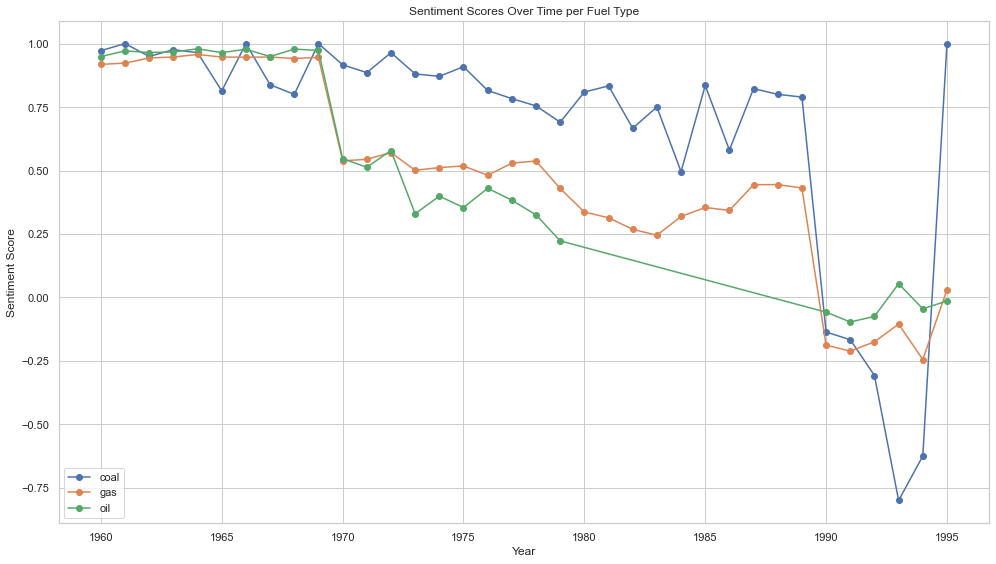

In [166]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Define a PyTorch model class
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Define a custom classifier that uses PyTorch
class PyTorchClassifier:
    def __init__(self, model, vectorizer, label_encoder, batch_size=16):  # Reduced batch size
        self.model = model
        self.vectorizer = vectorizer
        self.label_encoder = label_encoder
        self.batch_size = batch_size

    def predict(self, X):
        # Vectorize the text data
        X_vec = self.vectorizer.transform(X)
        
        # Convert data to PyTorch tensors in sparse format (CSR matrix)
        X_tensor = torch.tensor(csr_matrix(X_vec).toarray(), dtype=torch.float32)

        # Create DataLoader for batch processing
        dataset = TensorDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)

        # Evaluation
        self.model.eval()
        all_predictions = []
        with torch.no_grad():
            for batch in dataloader:
                inputs = batch[0]
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.numpy())
        
        return self.label_encoder.inverse_transform(all_predictions)

# Function to make predictions for a given dataset
def make_predictions(dataset_name, fuel_type):
    # Construct the file path based on dataset name and fuel type
    file_path = f"C:\\Users\\schol\\Thesis\\training model\\{dataset_name}_{fuel_type}_labeled_full_0.99.csv"
    df = pd.read_csv(file_path)

    # Load the model, vectorizer, and label encoder
    model_path = f"best_model_{dataset_name}.pth"
    vectorizer_path = f"vectorizer_{dataset_name}.pkl"
    label_encoder_path = f"label_encoder_{dataset_name}.pkl"
    
    checkpoint = torch.load(model_path)
    input_size = checkpoint['input_size']
    output_size = checkpoint['output_size']

    model = LogisticRegression(input_size, output_size)
    model.load_state_dict(checkpoint['model_state_dict'])
    vectorizer = joblib.load(vectorizer_path)
    label_encoder = joblib.load(label_encoder_path)
    
    # Create an instance of PyTorchClassifier with the loaded components
    classifier = PyTorchClassifier(model, vectorizer, label_encoder)

    # Process data in chunks to reduce memory usage
    batch_size = 1000
    num_chunks = len(df) // batch_size + 1
    predictions = []
    
    for i in range(num_chunks):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(df))
        chunk = df['text_clean'].iloc[start_idx:end_idx]
        chunk_predictions = classifier.predict(chunk)
        predictions.extend(chunk_predictions)

    # Add predictions to the DataFrame
    df['predicted_labels'] = predictions

    return df

# List of dataset names and fuel types
datasets = ['1960s', '1970s', '1980s', '1990s']
fuel_types = ['coal', 'gas', 'oil']

# Combine all predictions into a single DataFrame
combined_df = pd.DataFrame()

for dataset_name in datasets:
    for fuel_type in fuel_types:
        df = make_predictions(dataset_name, fuel_type)
        df['dataset'] = dataset_name
        df['fuel_type'] = fuel_type
        combined_df = pd.concat([combined_df, df])

# Convert the 'date' column to datetime format
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Map the numerical labels back to their original categories
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
combined_df['predicted_labels'] = combined_df['predicted_labels'].map(label_map)

# Function to calculate sentiment score
def calculate_sentiment_score(labels):
    label_counts = labels.value_counts()
    pos_count = label_counts.get('positive', 0)
    neu_count = label_counts.get('neutral', 0)
    neg_count = label_counts.get('negative', 0)
    total = pos_count + neu_count + neg_count
    if total == 0:
        return 0
    return (pos_count - neg_count) / total

# Calculate sentiment score per year per fuel type
combined_df['year'] = combined_df['date'].dt.year
sentiment_scores = combined_df.groupby(['fuel_type', 'year'])['predicted_labels'].apply(calculate_sentiment_score).reset_index()

# Plot the sentiment scores over time per fuel type
plt.figure(figsize=(14, 8))

for fuel_type in fuel_types:
    subset_df = sentiment_scores[sentiment_scores['fuel_type'] == fuel_type]
    plt.plot(subset_df['year'], subset_df['predicted_labels'], marker='o', label=fuel_type)

plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores Over Time per Fuel Type')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()